# Evaluate Primary Site and Tumor Normal Classifier

In [30]:
import os
import json
import requests
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

# Set so that Tensorflow can pull from the PRP S3/CEPH storage cluster
os.environ["S3_ENDPOINT"] = "s3.nautilus.optiputer.net"

# Switch to a scratch data directory so all paths are local
!mkdir -p ~/data/pancan-gtex
os.chdir(os.path.expanduser("~/data/pancan-gtex"))

# Load Trained Model and Test Data

In [13]:
# Load params and trained model from S3
r = requests.get("https://s3.nautilus.optiputer.net/stuartlab/{}/{}/models/params.json".format(
    os.environ["USER"], "pancan-gtex"))
params = r.json()

r = requests.get("https://s3.nautilus.optiputer.net/stuartlab/{}/{}/models/model.h5".format(
    os.environ["USER"], "pancan-gtex"))

import tempfile
temp_path = "/tmp/{}.h5".format(next(tempfile._get_candidate_names()))
open(temp_path, "wb").write(r.content)

model = tf.keras.models.load_model(temp_path)
os.remove(temp_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 6974)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6974)              27896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                446400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 46)                2990      
Total para

In [14]:
# Connect to S3 via boto3 so we can read and write
import boto3

bucket_name = "stuartlab"

session = boto3.session.Session(profile_name=os.getenv("AWS_PROFILE"))
bucket = session.resource(
    "s3", endpoint_url=os.getenv("AWS_S3_ENDPOINT")).Bucket(bucket_name)
print("S3 Profile: {} Endpoint: {} Bucket: {}".format(
    os.getenv("AWS_PROFILE"), os.getenv("AWS_S3_ENDPOINT"), bucket_name))

S3 Profile: prp Endpoint: https://s3.nautilus.optiputer.net Bucket: stuartlab


In [15]:
if not os.path.exists("pancan-gtex.h5"):
    print("Downloading dataset...")
    bucket.download_file("pancan-gtex/pancan-gtex.h5", "pancan-gtex.h5")
    
print("Loading dataset...")
X = pd.read_hdf("pancan-gtex.h5", "samples")
Y = pd.read_hdf("pancan-gtex.h5", "labels")
print("Loaded {} samples with {} features and {} labels".format(X.shape[0], X.shape[1], Y.shape[1]))

Loading dataset...
Loaded 17964 samples with 6974 features and 40 labels


In [16]:
# Convert tumor normal and primary site to numeric values so we can plot confusion and errors againsts them
from sklearn.preprocessing import LabelEncoder

primary_site_encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(primary_site_encoder.fit_transform(Y["_primary_site"]), index=Y.index)

tumor_normal_encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(tumor_normal_encoder.fit_transform(Y["tumor_normal"]), index=Y.index)

In [26]:
# Predict all test samples
X_test = X.iloc[params["test_indices"]]
Y_test = Y.iloc[params["test_indices"]]
predictions = model.predict(X_test)

## Evaluate

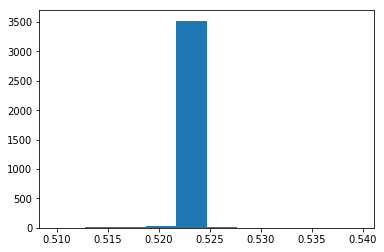

Tumor/Normal Confusion Matrix
[[   0 1642]
 [   0 1951]]


In [27]:
# Plot the distribution of tumor/normal values and confusion matrix
plt.hist(predictions[:,0])
plt.show()

from sklearn.metrics import confusion_matrix
print("Tumor/Normal Confusion Matrix")
print(confusion_matrix(Y_test["tumor_normal_value"], np.round(predictions[:,0])))

In [28]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix optionally normalized by class size
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

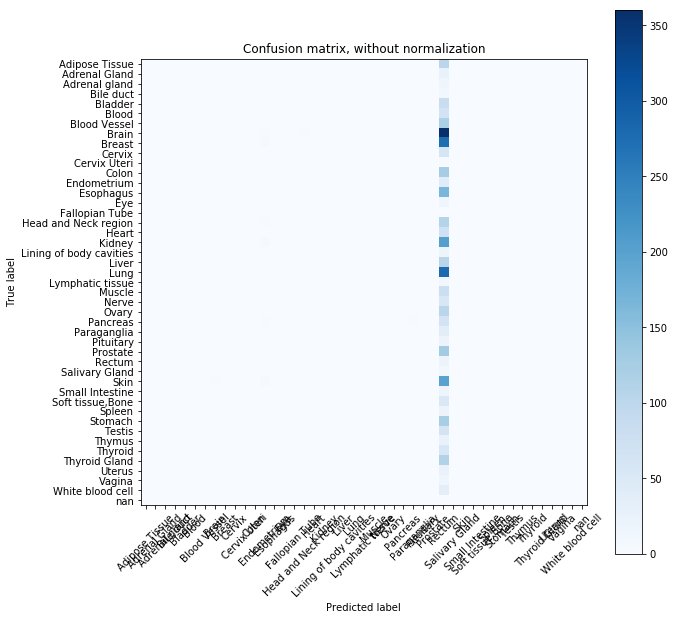

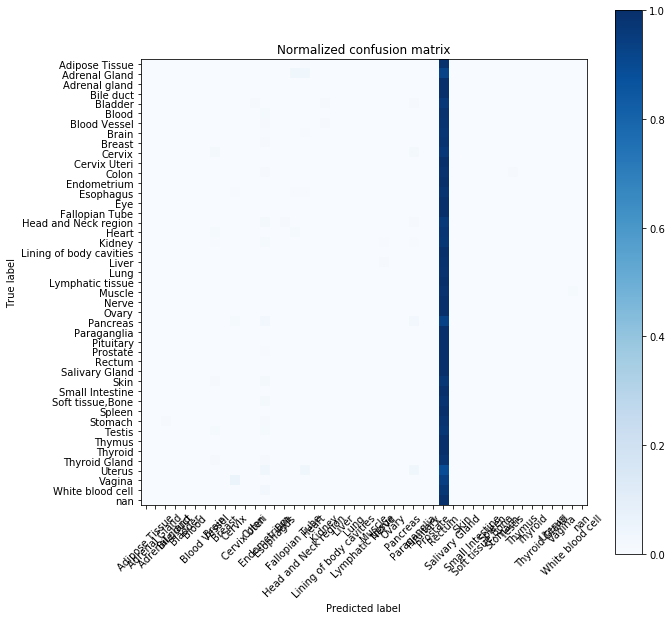

In [29]:
# Plot confusion matrix for primary site
import sklearn.metrics
import matplotlib.ticker as ticker

confusion_matrix = sklearn.metrics.confusion_matrix(
    Y_test["primary_site_value"], np.array([np.argmax(p[1:-1]) for p in predictions]))

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=params["primary_site"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=params["primary_site"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()